In [1]:
"""
From https://stackoverflow.com/questions/18228966/how-can-matplotlib-2d-patches-be-transformed-to-3d-with-arbitrary-normals
"""

def rotation_matrix(d):
    """
    Calculates a rotation matrix given a vector d. The direction of d
    corresponds to the rotation axis. The length of d corresponds to 
    the sin of the angle of rotation.

    Variant of: http://mail.scipy.org/pipermail/numpy-discussion/2009-March/040806.html
    """
    sin_angle = np.linalg.norm(d)

    if sin_angle == 0:
        return np.identity(3)

    d /= sin_angle

    eye = np.eye(3)
    ddt = np.outer(d, d)
    skew = np.array([[    0,  d[2],  -d[1]],
                  [-d[2],     0,  d[0]],
                  [d[1], -d[0],    0]], dtype=np.float64)

    M = ddt + np.sqrt(1 - sin_angle**2) * (eye - ddt) + sin_angle * skew
    return M

def pathpatch_2d_to_3d(pathpatch, z = 0, normal = 'z'):
    """
    Transforms a 2D Patch to a 3D patch using the given normal vector.

    The patch is projected into they XY plane, rotated about the origin
    and finally translated by z.
    """
    if type(normal) is str: #Translate strings to normal vectors
        index = "xyz".index(normal)
        normal = np.roll((1.0,0,0), index)

    normal /= np.linalg.norm(normal) #Make sure the vector is normalised

    path = pathpatch.get_path() #Get the path and the associated transform
    trans = pathpatch.get_patch_transform()

    path = trans.transform_path(path) #Apply the transform

    pathpatch.__class__ = art3d.PathPatch3D #Change the class
    pathpatch._code3d = path.codes #Copy the codes
    pathpatch._facecolor3d = pathpatch.get_facecolor #Get the face color    

    verts = path.vertices #Get the vertices in 2D

    d = np.cross(normal, (0, 0, 1)) #Obtain the rotation vector    
    M = rotation_matrix(d) #Get the rotation matrix

    pathpatch._segment3d = np.array([np.dot(M, (x, y, 0)) + (0, 0, z) for x, y in verts])

def pathpatch_translate(pathpatch, delta):
    """
    Translates the 3D pathpatch by the amount delta.
    """
    pathpatch._segment3d += delta


In [2]:
# matplotlib version

In [3]:

from mpl_toolkits import mplot3d
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, FancyArrowPatch, Arc
from mpl_toolkits.mplot3d import Axes3D, art3d
from mpl_toolkits.mplot3d import proj3d


In [4]:


import collections

Arguments = collections.namedtuple('Settings', 
        ('radius', 'height', 'elevation', 'resolution', 'color', 'x_center', 'y_center','alpha_elements','alpha', 'theta'))

args = Arguments(radius=10, height=3, elevation=0, resolution = 25, color = 'b', x_center=0, y_center=0,alpha_elements= 0.4, alpha=0.2, theta=0.94 )



In [5]:
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

<IPython.core.display.Javascript object>


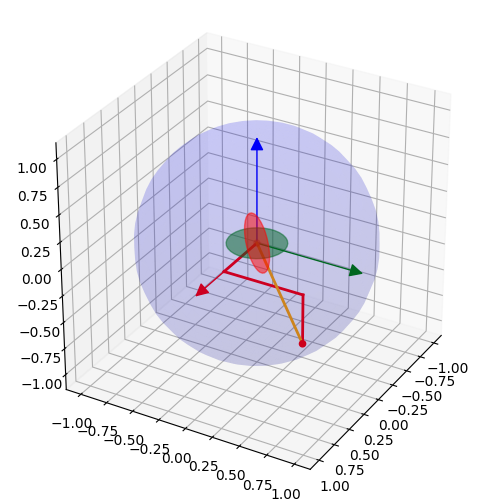

In [6]:
%matplotlib notebook
def sph2cart(r, theta, phi):
    return np.array([r*np.sin(theta)*np.cos(phi), r*np.sin(theta)*np.sin(phi), r*np.cos(theta)])

def draw_a_range(ax, center=(0, 0), normal=(0, 0, 1), height=0, radius=1, color="r", alpha=0.5):
    c = Circle(center, radius, color=color, alpha=alpha)
    ax.add_patch(c)
    pathpatch_2d_to_3d(c, z=0, normal=normal)

def draw_arrows(ax, **kwargs):
    defaults = {"mutation_scale":20, "lw":1, "arrowstyle":"-|>"}
    kwargs.update({k:v for k,v in defaults.items() if not k in kwargs})
    l = 1.0
    for c in "rgb":
        v = Arrow3D([0,l*(c=="r")],[0,l*(c=="g")],[0,l*(c=="b")], color=c, **kwargs)
        ax.add_artist(v)
        
def plot_3D_sphere(r, theta, phi):
    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig, azim=30, elev=30)

    # Plot Sphere
    u, v = np.mgrid[0:2*np.pi:30j, 0:np.pi:30j]
    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = np.cos(v)
    ax.plot_surface(x, y, z, color="b", alpha=.1)
    
    # Plot 3D point
    cart_pos = sph2cart(r, theta, phi)
    cart_positions = np.array([[0, 0, 0], cart_pos]).T
    ax.scatter3D(*cart_positions, c='r')
    
    cart_0 = [0, 0, 0]
    cart_x = [cart_pos[0], 0, 0]
    cart_xy = [cart_pos[0], cart_pos[1], 0]
    
    def plot_segment(a, b, **kwargs):
        ax.plot([a[0], b[0]], [a[1], b[1]], zs=[a[2], b[2]], **kwargs)
        
    # Plot path to point along each coordinate
    for a, b in ((cart_0, cart_x), (cart_x, cart_xy), (cart_xy, cart_pos)):
        plot_segment(a, b, lw=2, c="r")    
    plot_segment([0, 0, 0], cart_pos, lw=2, c="orange")
    
    # Draw ranges for theta and phi    
    draw_a_range(ax, radius=.25, color="r", height=0, normal=(-np.sin(phi), np.cos(phi), 0))
    draw_a_range(ax, radius=.25, color="g", height=0, normal=(0, 0, 1))
    
    # Draw axes
    draw_arrows(ax, lw=1)

    plt.show()


plot_3D_sphere(1, np.pi*.65, np.pi*.3)